
# ¿Cómo afinar la estrategia de colocación de tarjetas débito?

### Objetivo de negocio

Con el fin de profundizar el conocimiento de nuestros clientes y el uso que hacen de los medios de pago que el banco pone a su disposición, se hace necesario estudiar las características y comportamientos de los clientes que son usuarios activos de  tarjeta débito. Con esto se busca desarrollar un mejor entendimiento de este grupo de clientes para afinar estrategias de colocación de tarjetas y los planes de profundización transaccional que conlleven a generar mayores en ingresos asociados al uso de estas tarjetas.

### Preguntas de negocio
1. ¿Es adecuada la estrategia de colocación de tarjeta débito?
2. ¿Cuántos clientes hacen uso efectivo de su tarjeta débito?
3. ¿Cuántos empleados hacen parte de quienes usan su tarjeta débito activamente?
4. ¿Qué características sociodemográficas describen a esos clientes?
5. ¿Qué comportamientos trasnacionales describen a esos cliente?
6. ¿La zona afecta el comportamientos trasnacional de esos clientes?
7. ¿Cómo afecta el nivel de ingresos del cliente el uso de la tarjeta débito?
8. ¿Cómo afecta el saldo en cuentas de ahorro del cliente al uso de la tarjeta débito?
9. ¿Especificamente, que tipo y cuantas de transaciones realizan quienes usan su tarjeta débito?
10. ¿En que categorias de comercio (Supermercados, Restauranes, etc.) transan estos clientes?
11. ¿En que establecimientos de comercio transan estos clientes?
12. ¿Existen estructuras en los datos?

### Población de estudio

Clientes que han realizado por lo menos una transacción con su tarjeta debito en los últimos tres meses

## Desarrollo del análisis

### Importacion de paquetes

In [55]:
import pandas as pd  # Manipulacion de datos
import numpy as np   # algebra lineal
from sklearn import preprocessing as pre    # Preprocesamiento
import matplotlib.pyplot as plt    # Vizualizacion
import seaborn as sns
from sklearn.metrics import roc_curve, auc, accuracy_score   #Metricas del rendimiento
from scipy import interp
from sklearn.cluster import KMeans # Algoritmos de clusterizacion

# paquetes de ML
from sklearn.linear_model import LogisticRegression #Regresion logistica
from sklearn.svm import SVC #Maquina de soporte vectorial
from sklearn.ensemble import RandomForestClassifier # Bosque aleatorio
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB # Redes Bayesianas
from sklearn.tree import DecisionTreeClassifier # Arbol de decison
from sklearn.neural_network import MLPClassifier  # Red Neuronal
from sklearn.ensemble import AdaBoostClassifier # AdaBoost(Adaptive Boosting)
from sklearn.ensemble import GradientBoostingClassifier  #Stochastic Gradient Boosting
#import xgboost as xg # XGBoost (no tengo libreria)


from sklearn.ensemble import VotingClassifier
#from sklearn.model_selection import train_test_split # Division entrenamiento evaluacion
#from sklearn import metrics # medida de presicion
from sklearn.metrics import confusion_matrix, f1_score # matriz de confusion
from sklearn.model_selection import KFold, StratifiedKFold # validacion cruzada
from sklearn.model_selection import cross_val_score #score evaluacion
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import GridSearchCV

import itertools # Iteración
import os # Rutas y directorio
import warnings # Manejar advertencias

import pickle # Serializar el modelo

In [2]:
# Establecer directorio de trabajo
warnings.filterwarnings('ignore')

os.chdir(r'C:\Users\czamora\Documents\04_Perfil_TD')
print ('Directorio actual: '+ os.getcwd()); print ('\n')

plt.style.use('seaborn')

Directorio actual: C:\Users\czamora\Documents\04_Perfil_TD




In [4]:
# Importar datos
cl_0a = pd.read_csv('MineriaClusterBeta_201910.txt',sep ='\t',encoding = 'latin-1')
MFC953 = pd.read_csv('MFC953.csv',sep =';',encoding = 'latin-1',decimal =',')

In [5]:
# Derivar campos data mineria
cl_0a['Edad_Esc'] = pre.StandardScaler().fit_transform(cl_0a[['EDAD']])
cl_0a['Antiguedad_Esc'] = pre.StandardScaler().fit_transform(cl_0a[['ANTIGUEDAD']])
cl_0a['Ingresos_QQGa'] = pre.QuantileTransformer(output_distribution='normal').fit_transform(cl_0a[['INGRESOS_DC_V']])
cl_0a['SdoAhorro_QQGa'] = pre.QuantileTransformer(output_distribution='normal').fit_transform(cl_0a[['SDO_AHOR']])

In [6]:
# Instanciar variables
MFC953['SALDO_RETIRO'] = MFC953.SALDO_RETIRO.astype(int)
MFC953['SALDO_COMPRA'] = MFC953.SALDO_COMPRA.astype(int)
MFC953['SALDO_CONSULTA'] = MFC953.SALDO_CONSULTA.astype(int)
MFC953['contador'] = 1

In [7]:
# Agupar df
MFC953_agg = MFC953.groupby(['PEPAIS', 'PETDOC', 'PENDOC']).sum().reset_index()

ptable = pd.pivot_table(MFC953, values='CANTIDAD_TRANSACCIONES',index=['PEPAIS', 'PETDOC', 'PENDOC'],
                        columns=['MES_CORTE'],aggfunc=np.sum, fill_value=0).reset_index().\
                        rename(columns={201908: 'tx_tot_08',201909: 'tx_tot_09',201910: 'tx_tot_10'})

MFC953_agg = pd.merge(MFC953_agg, ptable, how='left', left_on=['PEPAIS', 'PETDOC', 'PENDOC']
                    ,right_on=['PEPAIS', 'PETDOC', 'PENDOC'])

In [8]:
# Unir las tablas
perfil_TD = pd.merge(MFC953_agg, cl_0a, how='inner', left_on=['PEPAIS', 'PETDOC', 'PENDOC']
                    ,right_on=['PAIS_DOC', 'TIPO_DOC', 'NRO_DOC'])

### Sobrerepresentación 


In [9]:
# Costrucción datos de Modelamiento
col_names = cl_0a.columns.tolist()

model_df_0 = perfil_TD[perfil_TD['EMPLEADO_BMM'] != 1][col_names]
model_df_0['target']=1

model_df_1 = cl_0a[(cl_0a['AHORRO_DUMMY']==1) & (cl_0a['EMPLEADO_BMM']!=1) & (cl_0a['EDAD']!=999)].sample(8608)
model_df_1['target']=0

model_df_2 = pd.concat([model_df_0,model_df_1], axis = 0)

In [10]:
print(model_df_2.columns.tolist())

['PAIS_DOC', 'TIPO_DOC', 'NRO_DOC', 'EMPLEADO_BMM', 'GENERO', 'EDAD', 'GENERACION', 'GENERACION_ENC', 'GENERACION_MIL2', 'GENERACION_MIL_X_2', 'NIV_EDUC', 'NIV_EDUC2', 'ZONA', 'DEPTO_RES', 'MCPIO_RES', 'EST_CIVIL', 'NRO_ACARGO', 'TIPO_VVDA2', 'ACTIVIDAD', 'ANTIGUEDAD', 'ANTIGUEDAD_2', 'ANTIGUEDAD_3', 'INGRESOS_DC_V', 'INGRESOS_DC_V_2', 'INGRESOS_DC_V_3', 'INGRESOS_DC_V_31', 'INGRESOS_DC', 'EGRESOS_DC', 'ACTIVOS_DC', 'PASIVOS_DC', 'CREDITO_DUMMY', 'CANT_CRED', 'SDO_CRED', 'CDT_DUMMY', 'CANT_CDT', 'SDO_CDT', 'AHORRO_DUMMY', 'CANT_AHOR', 'SDO_AHOR', 'CHQTN_DUMMY', 'CANT_PAS', 'SDO_PAS', 'VOL_TOT', 'CTA_DES', 'PROF_CAT', 'PROF_PR', 'PR_HIST', 'CATEGORIA', 'RECENCIA', 'FRECUENCIA', 'MONTO', 'RECENCIA_D', 'FRECUENCIA_D', 'MONTO_D', 'RECENCIA_BINS', 'FRECUENCIA_BINS', 'MONTO_BINS', 'RFM_D', 'RFM_BINS', 'SEG_CHQTNS', 'SEG_DISENGAG', 'SEG_DISENGAG_2', 'Edad_Esc', 'Antiguedad_Esc', 'Ingresos_QQGa', 'SdoAhorro_QQGa', 'target']


In [11]:
model_df_2.shape

(12297, 67)

In [12]:
model_df_2['DEPTO_RES'] = model_df_2['DEPTO_RES'].astype(str).str.strip()
model_df_2['MCPIO_RES'] = model_df_2['MCPIO_RES'].astype(str).str.strip()

In [13]:
cudades_p = ['BARRANQUILLA', 'BOGOTA', 'CARTAGENA', 'POPAYAN', 'VILLAVICENCIO', 'CALI', 'RIOHACHA', 'SANTA MARTA', 'SOLEDAD',
             'IBAGUE', 'SAN JUAN DE PASTO', 'VALLEDUPAR', 'YOPAL', 'JAMUNDI', 'SANTANDER DE QUILICHAO', 'PEREIRA', 'MONTERIA',                      
             'NEIVA', 'ARMENIA', 'PALMIRA']

model_df_2['ciudad_dummy'] = model_df_2['MCPIO_RES'].isin(cudades_p).astype(int)

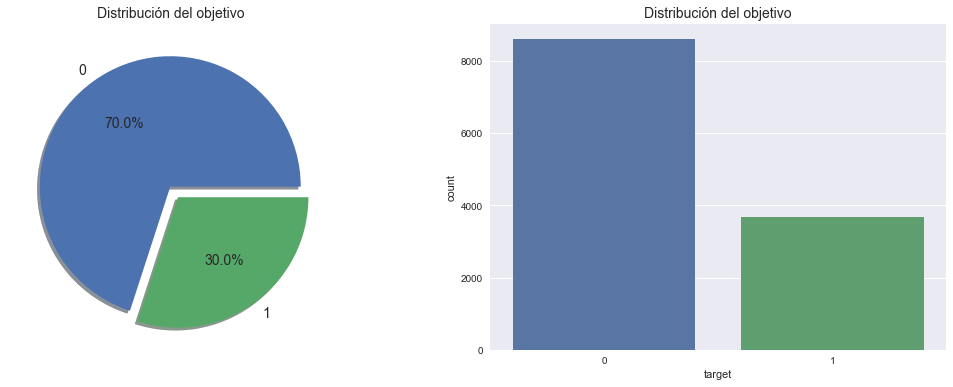

<Figure size 576x396 with 0 Axes>

In [14]:
# Distribución del objetivo
f,ax=plt.subplots(1,2,figsize=(18,6))
model_df_2['target'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],
                                             shadow=True, textprops={'fontsize': 14})
ax[0].set_title('Distribución del objetivo', fontsize= 14)
ax[0].set_ylabel('')
sns.countplot('target',data=model_df_2,ax=ax[1])
ax[1].set_title('Distribución del objetivo', fontsize= 14)
plt.show()

plt.savefig('DistribucionObjetivo.png', dpi=900)

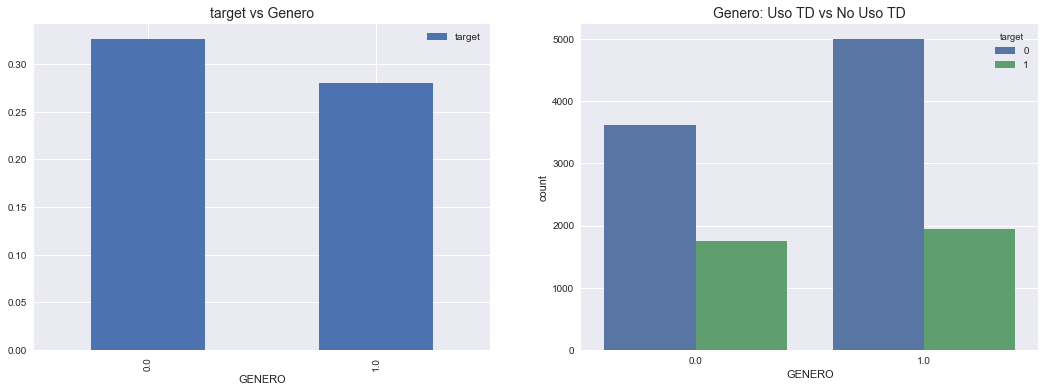

In [15]:
f,ax=plt.subplots(1,2,figsize=(18,6))
model_df_2[['GENERO','target']].groupby(['GENERO']).mean().plot.bar(ax=ax[0])
ax[0].set_title('target vs Genero', fontsize= 14)
sns.countplot('GENERO',hue='target',data=model_df_2,ax=ax[1])
ax[1].set_title('Genero: Uso TD vs No Uso TD', fontsize= 14)
plt.show()

In [16]:
genero_1 = model_df_2[['GENERO','target']].groupby(['GENERO'], as_index = False).\
            mean().sort_values(by='target', ascending=False)
genero_2 = model_df_2[['GENERO','target']].groupby(['GENERO'], as_index = False).\
            count().sort_values(by='target', ascending=False)
genero_mg = pd.merge(genero_1, genero_2, how = 'left', on ='GENERO')

### Relación de las variables categoricas con el objetivo

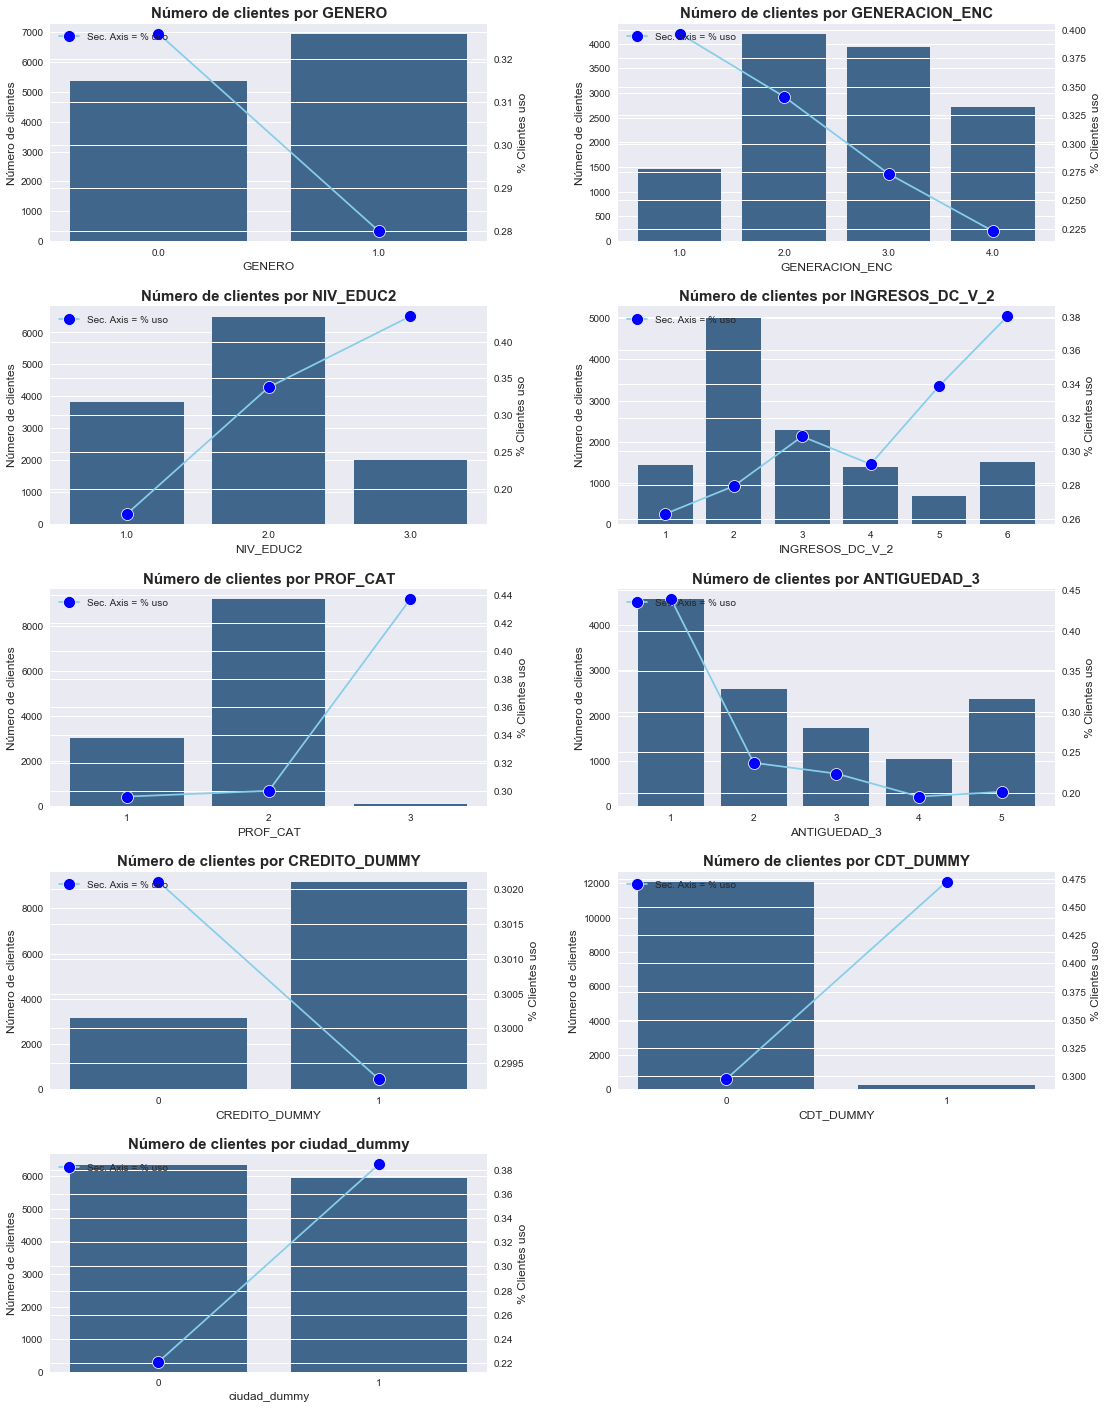

In [17]:
var_s = ['GENERO', 'GENERACION_ENC', 'NIV_EDUC2','INGRESOS_DC_V_2', 'PROF_CAT', 'ANTIGUEDAD_3',
         'CREDITO_DUMMY', 'CDT_DUMMY', 'ciudad_dummy']

plt.figure(figsize=(18,30))
n = 0
for var in var_s:

    df_1 = model_df_2[[var,'target']].groupby([var], as_index = False).mean().sort_values(by = var, ascending=False)
    df_2 = model_df_2[[var,'target']].groupby([var], as_index = False).count().sort_values(by = var, ascending=False)
    df_mg = pd.merge(df_1, df_2, how = 'left', on =var)
    
    n+=1
    plt.subplot(6,2,n)
    plt.subplots_adjust(hspace =0.3 , wspace = 0.3)
    sns.barplot(df_mg[var], df_mg['target_y'], color=(0.2, 0.4, 0.6, 0.6))
    plt.ylabel('Número de clientes', fontsize = 12)
    plt.xlabel('{}'.format(var), fontsize = 12)
    ax2 = plt.twinx()
    sns.lineplot(df_mg[var].astype(str), df_mg['target_x'], markers = True, marker='o', markerfacecolor='blue', 
                 markersize=12, color='skyblue', ax = ax2)
    plt.ylabel('% Clientes uso', fontsize = 12)
    plt.title('Número de clientes por {}'.format(var), fontsize = 15, fontweight='bold')
    plt.legend(['Sec. Axis = % uso'], loc = 'upper left')

plt.savefig('Relaciones_TD.png', dpi=900)    

### Relación de las variables continuas con el objetivo

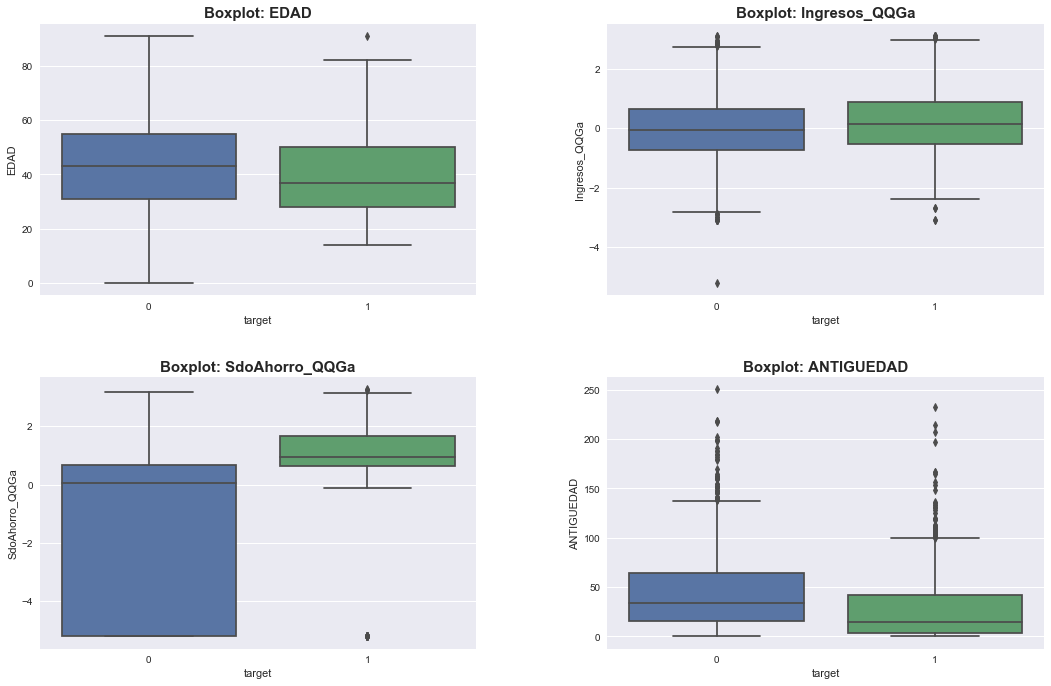

<Figure size 576x396 with 0 Axes>

In [18]:
var_n = ['EDAD', 'Ingresos_QQGa', 'SdoAhorro_QQGa', 'ANTIGUEDAD']

plt.figure(1, figsize=(18,18))
n = 0
for var in var_n:
    n+=1
    plt.subplot(3,2,n)
    plt.subplots_adjust(hspace =0.3 , wspace = 0.3)
    sns.boxplot(x = model_df_2['target'], y = model_df_2[var])
    plt.title('Boxplot: {}'.format(var), fontsize = 15, fontweight='bold')
plt.show()
plt.savefig('RelacionesInt_TD.png')  

========================================================================================================================

## Modelamiento

In [19]:
x_var = ['Edad_Esc', 'Ingresos_QQGa', 'SdoAhorro_QQGa', 'Antiguedad_Esc', 'NIV_EDUC2', 'PROF_CAT', 'ciudad_dummy']

X = model_df_2[x_var]
y = model_df_2['target']

In [20]:
# Modelos 
classifiers=['Linear Svm',
             'Radial Svm',
             'Logistic Regression',
             'KNN',
             'Decision Tree',
             'Naive Bayes',
             'Random Forest', 
             'Neural Network',
             'Adaptive Boosting',
             'Stochastic Gradient']

models=[SVC(kernel='linear'),
        SVC(kernel='rbf'),
        LogisticRegression(),
        KNeighborsClassifier(n_neighbors=9),
        DecisionTreeClassifier(),
        GaussianNB(),
        RandomForestClassifier(n_estimators=100),
        MLPClassifier(alpha=1, max_iter=1000),
        AdaBoostClassifier(),
        GradientBoostingClassifier()]

In [21]:
kfold = StratifiedKFold(n_splits=5, shuffle = True ,random_state=2019) # k=10, split the data into 5 equal parts

accuracy=[]  # the accuracy score for the 5 folds of each model
std=[]       # the standard deviation for the 5 folds of each model
aucs = []    # the mean roc_auc for the 5 folds of each model
tprs = []
summary = []
mean_fpr = np.linspace(0, 1, 100)  # >>>|!|<<<
for i, model in enumerate (models):
    accuracy=[]
    for train, test in kfold.split(X, y):
        model_0 = model
        model_fit = model_0.fit(X.iloc[train],y.iloc[train])
        probas_ = model_0.predict(X.iloc[test])
        
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_)  # roc_curve values for iteration
        # tpr
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        
        # AUC
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
        # Accuaracy
        accuracy.append(accuracy_score(y.iloc[test], probas_))   # >>>|!|<<<
        
    # tpr    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0       # >>>|!|<<<
    
    # AUC
    mean_auc = auc(mean_fpr, mean_tpr) # >>>|!|<<<
    std_auc = np.std(aucs)   # >>>|!|<<<
    
    summary_0 =[classifiers[i], mean_tpr, mean_auc, std_auc, accuracy]
    summary.append(summary_0)   

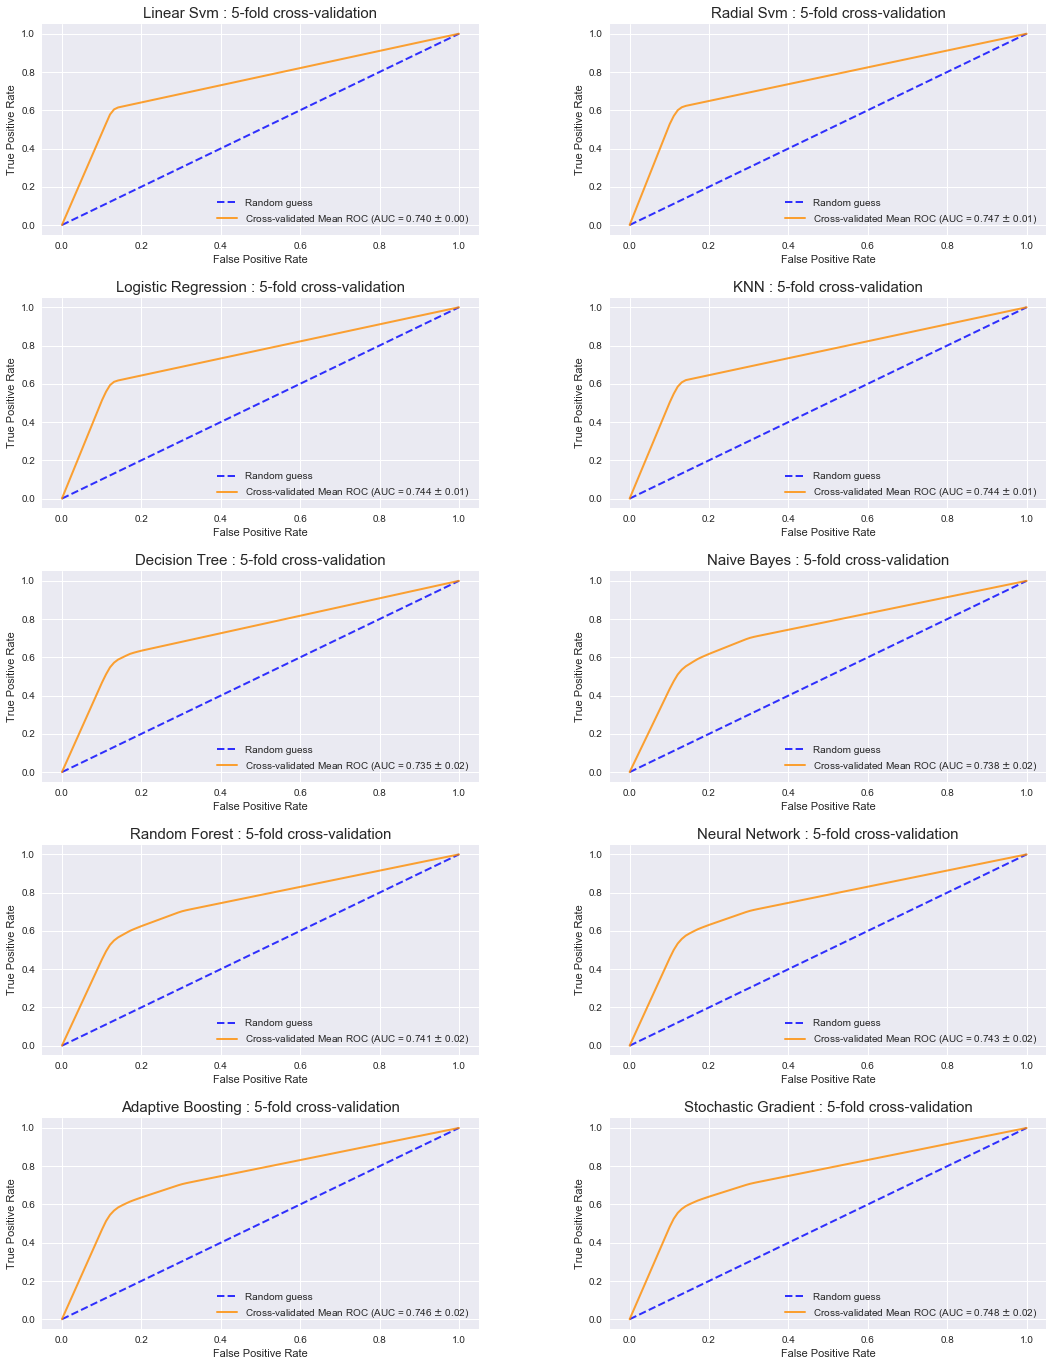

In [22]:
AUC = []
STD = []

plt.figure(figsize=(18,24))
for i , classifier in enumerate(classifiers):
    roc_plot = summary[i]
    plt.subplot(5,2,i+1)
    plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue', label='Random guess', alpha=.8)
    plt.plot(mean_fpr, roc_plot[1], color='darkorange', lw=2, alpha=.8,
             label=r'Cross-validated Mean ROC (AUC = %0.3f $\pm$ %0.2f)' % (roc_plot[2], roc_plot[3]))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.title('{} : 5-fold cross-validation'.format(roc_plot[0]), fontsize = 15)
    
    AUC.append(roc_plot[2])
    STD.append(roc_plot[3])
plt.show()

models_ROC =pd.DataFrame({'AUC_Mean':AUC,'Std':STD},index=classifiers)

In [23]:
models_ROC.sort_values(by='AUC_Mean', ascending=False)

,AUC_Mean,Std
Stochastic Gradient,0.747705,0.019867
Radial Svm,0.747145,0.008702
Adaptive Boosting,0.745527,0.019340
Logistic Regression,0.743807,0.008940
KNN,0.743761,0.009521
Neural Network,0.743244,0.019130
Random Forest,0.741082,0.018968
Linear Svm,0.740341,0.004076
Naive Bayes,0.738339,0.019014
Decision Tree,0.735414,0.019162


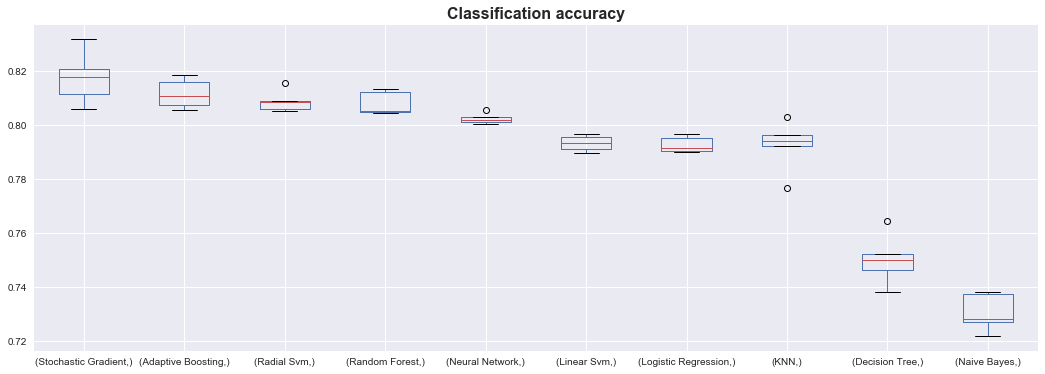

In [24]:
acc_box_0 = []
for i in summary:
    acc_box_0.append(i[4])
    
acc_box = pd.DataFrame(acc_box_0, index = [classifiers])
order = acc_box.T.mean().sort_values(ascending=False).index.tolist()
acc_box = acc_box.T[order]
plt.subplots(figsize=(18,6))
acc_box.boxplot()
plt.title('Classification accuracy', fontsize=16, fontweight='bold')

plt.savefig('ClassificationAccuracy.png', dpi=900)    

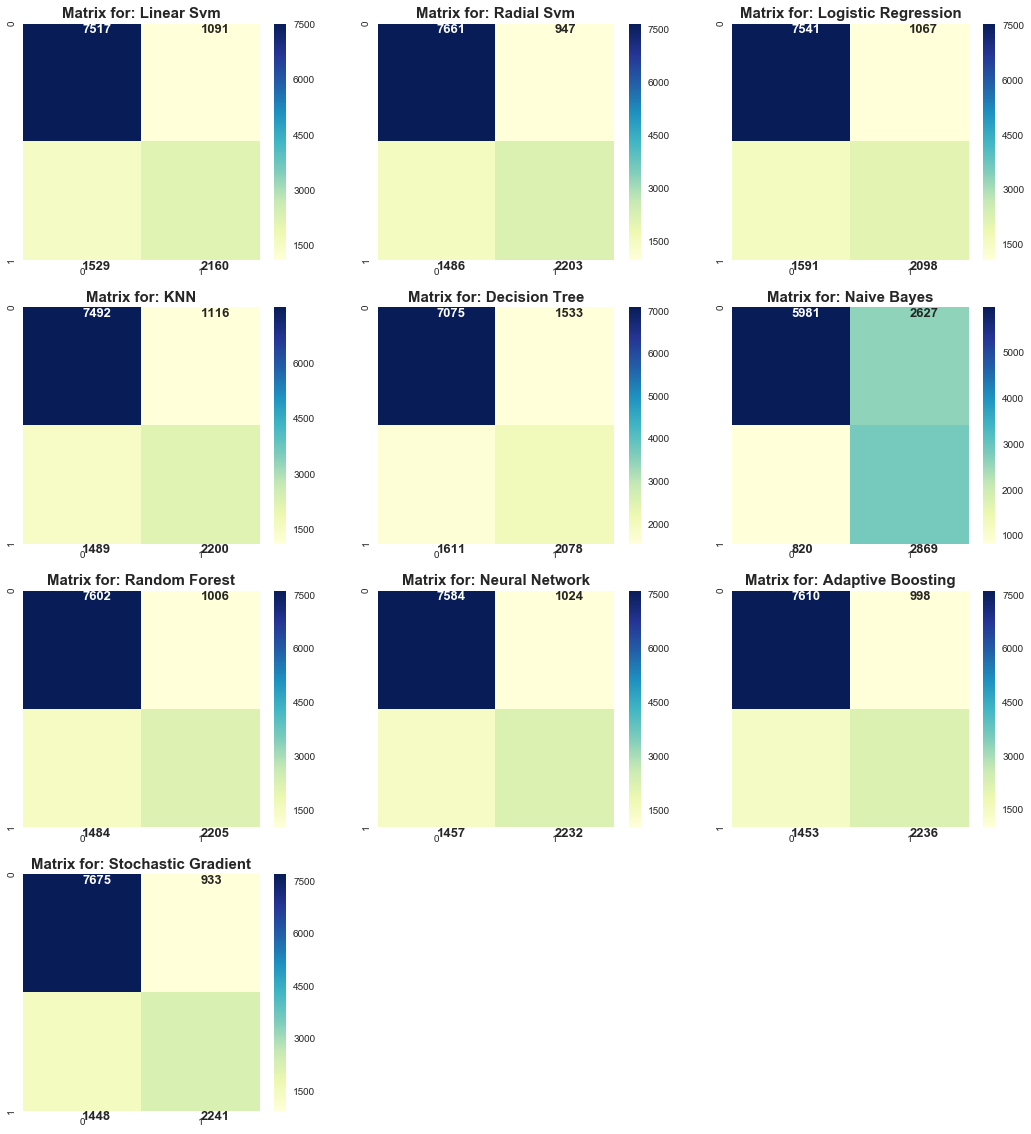

In [25]:
plt.figure(1, figsize=(18,20))
n = 0
for model in models:
    n+=1
    plt.subplot(4,3,n)
    y_pred = cross_val_predict(model,X,y,cv=10)
    c_m = confusion_matrix(y,y_pred)
    sns.heatmap(c_m,annot=True, annot_kws={'fontsize':13, 'fontweight':'bold', "ha": 'left',"va": 'top'}, 
                fmt='2.0f', cmap='YlGnBu')
    plt.title('Matrix for: {}'.format(classifiers[n-1]), fontsize = 15, fontweight='bold')

##### Selección del modelo

Para la seleccion de los modelos que entran a una etapa de hyper parameter turning descartamos algunos modelos basados en las métricas del ROC_AUC y la presición lograda. Al tomar los clasificadore top 5 de los modelos para cada una de estas métricas encontramos que cuatro que coinciden en cada top, estos son 

1. La maquina de soporte vectorial con kernel radial
2. La red neuronal (perceptrón multicapa)
3. La regresión logística
4. El bosque aleatorio

Con estos modelos se procede a hacer Hyper-Parameter Turninig para lograr los modelos óptimos que posteriormente haran parte de un modelo de clasificación ensamblado. 

### Hyper-Parameter Turninig

Los modelos de aprendizaje automático son como un Black-Box. Hay algunos valores de parámetros predeterminados para este Black-Box, que podemos ajustar para obtener un mejor modelo. Es el caso de C y gamma en el modelo SVM y parámetros igualmente diferentes para diferentes clasificadores, se denominan hiperparámetros, que podemos ajustar para cambiar la velocidad de aprendizaje del algoritmo y obtener un mejor modelo. Esto se conoce como ajuste de hiperparámetros.

In [58]:
# Maquina de soporte vectorial
C=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
gamma=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

hyper={'C':C,'gamma':gamma}
gd=GridSearchCV(estimator=SVC(kernel='rbf', probability = True),param_grid=hyper,verbose=True, scoring = 'f1')
gd.fit(X,y)
best_SVM = gd.best_estimator_
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 33.1min finished


0.5753718446290051
SVC(C=0.6, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.5, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


In [59]:
# Red neuronal
activation = ['identity', 'logistic', 'tanh', 'relu']
solver = ['lbfgs', 'sgd', 'adam']
alpha = [0.0001,0.001,0.01,0.1,1,10,100]
learning_rate = ['constant', 'invscaling', 'adaptive']

hyper={'activation': activation, 'solver':solver, 'alpha': alpha, 'learning_rate':learning_rate}
gd=GridSearchCV(estimator=MLPClassifier(),param_grid=hyper,verbose=True, scoring = 'f1')
gd.fit(X,y)
best_NN = gd.best_estimator_
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 3 folds for each of 252 candidates, totalling 756 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 756 out of 756 | elapsed: 44.9min finished


0.5805440709424586
MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='invscaling',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)


In [61]:
# Regresión logística
penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
solver = ['liblinear', 'saga']

hyper={'penalty': penalty, 'C':C, 'class_weight':class_weight, 'solver':solver}
gd=GridSearchCV(estimator=LogisticRegression(),param_grid=hyper,verbose=True, scoring = 'f1')
gd.fit(X,y)
best_LR = gd.best_estimator_
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.6483220514764098
LogisticRegression(C=0.01, class_weight={0: 0.3, 1: 0.7}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)


[Parallel(n_jobs=1)]: Done 384 out of 384 | elapsed:   11.7s finished


In [ ]:
# Bosque aleatorio
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyper={'n_estimators':n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 
       'min_samples_leaf':min_samples_leaf}
gd=GridSearchCV(estimator=RandomForestClassifier(random_state=0),param_grid=hyper,verbose=True, scoring = 'f1')
gd.fit(X,y)
best_RF=gd.best_estimator_
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [30]:
# Adaptative boosting
n_estimators=list(range(100,1100,100))
learn_rate=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]

hyper={'n_estimators':n_estimators,'learning_rate':learn_rate}
gd=GridSearchCV(estimator=AdaBoostClassifier(),param_grid=hyper,verbose=True, scoring = 'f1')
gd.fit(X,y)
best_AB = gd.best_estimator_
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 18.6min finished


0.7658778563877369
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.2,
                   n_estimators=700, random_state=None)


In [31]:
# Stochastic Gradient
n_estimators=list(range(100,1100,100))
learn_rate=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]

hyper={'n_estimators':n_estimators,'learning_rate':learn_rate}
gd=GridSearchCV(estimator=GradientBoostingClassifier(),param_grid=hyper,verbose=True, scoring = 'f1')
gd.fit(X,y)
best_GB = gd.best_estimator_
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 11.9min finished


0.766609742213548
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


### Modelo ensamblado (Voting Classifier)

Es la forma más sencilla de combinar predicciones de muchos modelos diferentes de aprendizaje automático. Da un resultado de predicción promedio basado en la predicción de todos los submodelos. Los submodelos o los modelos base son todos de diferentes tipos.

In [42]:
stuff = [('SVM', best_SVM), ( 'NN', best_NN), ( 'LR', best_LR), ( 'RF', best_RF),
         ( 'AB', best_AB), ( 'GB', best_GB), ( 'NB', GaussianNB())]

best_acc = -np.infty
for L in range(1, len(stuff)+1):
    for estimators in itertools.combinations(stuff, L):
        estimators_ls = list(estimators)
        ensemble_model =VotingClassifier(estimators=estimators_ls, voting='soft').fit(X.iloc[train],y.iloc[train])
        acc = ensemble_model.score(X.iloc[test],y.iloc[test])
        
        if acc > best_acc:
            best_estimators = estimators_ls
            best_acc = acc
            best_ens = ensemble_model 

In [49]:
print(best_estimators)
print(best_acc)
estima =estimators_ls

[('NN', MLPClassifier(activation='logistic', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='adaptive',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)), ('LR', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)), ('RF', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes

In [57]:
ensemble_model =VotingClassifier(estimators=[('SVM', best_SVM),
                                              #( 'NN', best_NN),
                                              #( 'LR', best_LR),
                                              #( 'RF', best_RF),
                                              #( 'AB', best_AB),
                                              #( 'GB', best_GB),
                                              ( 'NB', GaussianNB())], 
                       voting='soft').fit(X.iloc[train],y.iloc[train])

print('The accuracy for ensembled model is:',ensemble_model.score(X.iloc[test],y.iloc[test]))

cross=cross_val_score(ensemble_model,X,y, cv = 5,scoring = 'f1')
print('The cross validated score is',cross.mean())

The accuracy for ensembled model is: 0.7945484133441822
The cross validated score is 0.6108895758086803


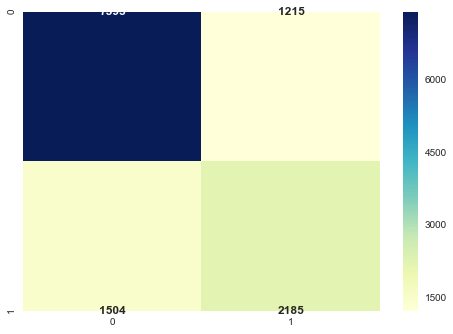

In [54]:
y_pred = cross_val_predict(ensemble_model,X,y,cv=5)
sns.heatmap(confusion_matrix(y,y_pred),annot=True, annot_kws={'fontsize':12, 'fontweight':'bold'}, fmt='2.0f', cmap='YlGnBu')

### Guardar el modelo (Serialización del modelo)

Este proceso / procedimiento de guardar un modelo ML también se conoce como serialización de objetos, que representa un objeto con una secuencia de bytes, para almacenarlo en el disco, enviarlo a través de una red o guardarlo en una base de datos.

In [142]:
Pkl_Filename = 'TD_Model.pkl' 

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(ensemble_model, file)